In [1]:
### 4C16 Lab 5 - Convolutional Neural Nets for Image Classification.

In [2]:
# Import the necessary modules

import keras
from keras import datasets
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.layers import PReLU, LeakyReLU, Conv2D, MaxPool2D, Lambda
from keras.regularizers import l2

from keras.models import model_from_json

from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator

import pickle
import sklearn as skl

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score

Using TensorFlow backend.


In [3]:
# Define some useful functions
class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.plot([1, 2])
        plt.subplot(121) 
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Model Loss')
        plt.legend()
        plt.subplot(122)         
        plt.plot(self.x, self.acc, label="training accuracy")
        plt.plot(self.x, self.val_acc, label="validation accuracy")
        plt.legend()
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title('Model Accuracy')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();
        
def save_model_to_disk():    
    # save model and weights (don't change the filenames)
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("model.h5")
    print("Saved model to model.json and weights to model.h5")

loading the dataset...
loaded.
let's look at some of the pictures and their ground truth labels:


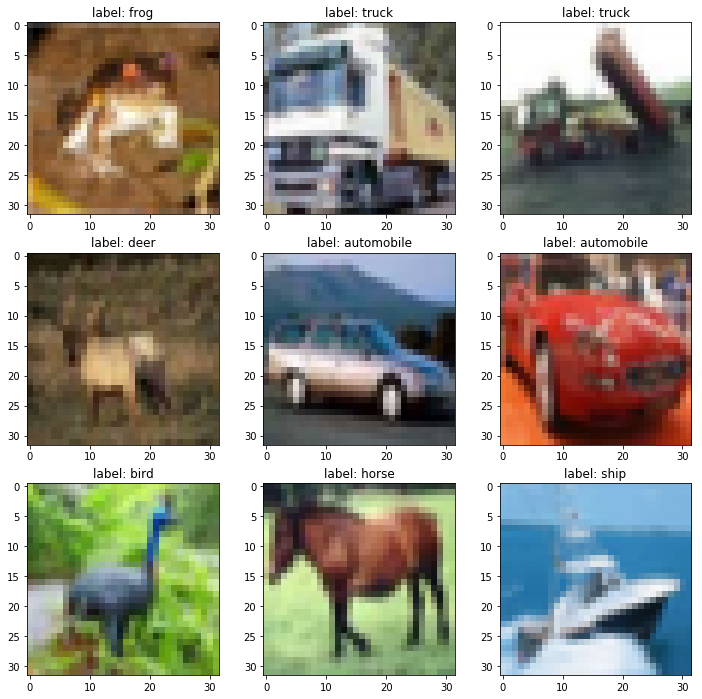

In [4]:
print('loading the dataset...')

pkl_file = open('/home/tcd/codiad/workspace/data/cifar10-dataset.pkl', 'rb')
dataset = pickle.load(pkl_file)

print('loaded.')

print('let\'s look at some of the pictures and their ground truth labels:')

plt.figure(figsize=(12,12))
plt.plot([3, 3])

X = dataset['X'].astype('float32')/255
Y = dataset['Y'].astype('float32')
Y = keras.utils.to_categorical(Y)

for i in range(0,9):
    # pictures are 32x32x3 (width=32, height=32, 3 colour channels)
    pic = X[i]

    # Y[i] returns an array of zeros and with Y[i][classid] = 1
    # for instance  Y[i] = [ 0 0 0 0 0 1 0 0 0 0] => classid=5 
    #          and  Y[i] = [ 1 0 0 0 0 0 0 0 0 0] => classid=0
    # we can get the classid by using the argmax function on the vector Y[i]
    classid = Y[i].argmax(-1)

    # getting back the name of the label for that classid
    classname = dataset['labels'][classid]
    plt.subplot(3,3,i+1)
    plt.imshow(pic)
    plt.title('label: {}'.format(classname))


In [5]:
# let's split data between validation set and training set

X_train, X_validation, Y_train, Y_validation = skl.model_selection.train_test_split(X, Y, test_size=.1, random_state=0)
# print(X_train.shape[1:])

In [9]:
# The model below contains 2 hidden layers with 64 nodes each. 
# The activation functions for these 2 layers is the ReLU
# The network ends with a 10 nodes layer with softmax activation
# The first 2 hidden layers transform the original features into 
# a new feature vector of size 64.
# The last layer essentially does the classification using multonomial regression
# based on these new features. 

inputs = keras.layers.Input(shape=(32, 32, 3))

# Replace these two lines with some convolutional layers;
# see keras docs for Conv2D, MaxPool2D, etc.
# Maybe stick in some Dropout as well?
x = Conv2D(32, kernel_size = (3, 3), activation='relu')(inputs)
x = MaxPool2D(pool_size=(2,2))(x)
x = Conv2D(64, kernel_size = (3, 3), activation='relu')(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Conv2D(256, kernel_size = (3, 3), activation='relu')(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Dropout(0.5)(x)
x = Flatten()(x)  # Don't flatten until after your 2D layers 
x = Dense(700, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(700, activation='relu')(x)
x = Dropout(0.5)(x)


# The last layers of your model should look something like
# this to be well-structured for the final classification:
# x = Flatten()(x)
# x = Dense(100, activation=None)(x)  # You could have a few more non-2D layers here

predictions = Dense(10, activation='softmax')(x)  # There are 10 classes in this problem, hence the '10'.

# Create the model.
model = keras.models.Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Setup the optimisation strategy.
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display a summary.
model.summary()

# Keep things sane.
if (model.count_params() > 10000000):    
    raise("Your model is unecessarily complex, scale down!")


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 256)         147712    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 2, 2, 256)         0         
__________

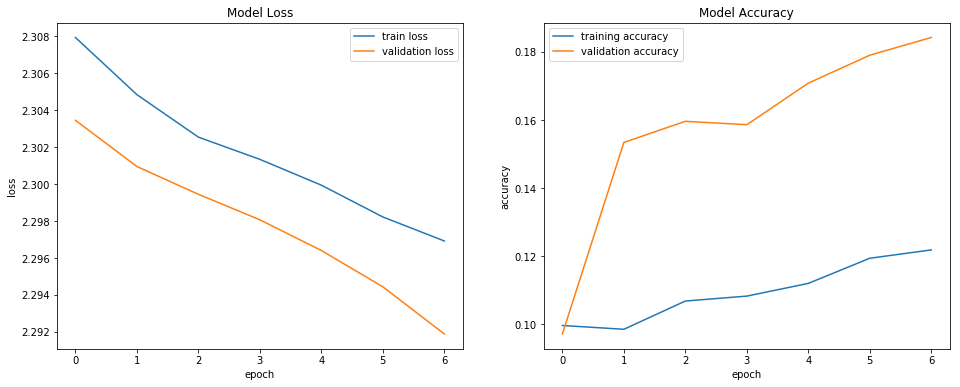

In [ ]:
# Note that you can evaluate this cell repeatedly to push the training of your model further.
# You might want to reduce the value of 'num_epochs' if each evaluation starts to take too long.

num_epochs = 160

# Create an instance of our callback functions class, to plot our loss function and accuracy with each epoch.
pltCallBack = PlotLossAccuracy()

# Run the training.
model.fit(X_train, Y_train,
          batch_size=4096, epochs=num_epochs, 
          validation_data=(X_validation, Y_validation), 
          callbacks=[pltCallBack])


In [ ]:
# write model to model.json and weights to model.h5 for submission

save_model_to_disk()

In [ ]:
# In the terminal, add these files to git and submit the lab
# Do the following: 
#  git add lab-05/model.json lab-05/model.h5
#  git commit -m "Added NN model."
#  git push
#  submit-lab 5

In [ ]:
# Question 1: design a network using a mix of convolutional and Dense layers, and achieve 60% accuracy on the server's test set
#
#  Do 'git commit -a -m "model update"' followed by 'submit-lab 5' to check your solution.
#
# Question 2: push your accuracy up to as high as 80%.
#
# You may want to test the following:
#
# Change the architecture: 
#    for instance you may want to add layers, 
#    change the number of units per layer, 
#    change the activation functions
#
# Always check on your accuray and loss graphs that that you are not overfitting. 
#
# Remember that you can help avoiding overfitting using 
#   - Dropout [https://keras.io/layers/core/#dropout]
#   - Regularisers (eg. L2, L1) [https://keras.io/regularizers/]
#
# Optimiser. You may get faster convergence using different optimiser that rmsprop (but rmsprop is not bad)
#
# Learning Rate. You can tune it.
##
# Also note that Deeper networks will require longer training times.
#
# Good luck!
#
#
# F.A.Q.
#
#   I reached 61% on my validation set, but the submission didn't pass, how come? 
#     > the test set on the server is different from your validation set
#   Can I use convolutional layers? 
#     > You must!
#


